# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Drop 'id' column

In [5]:
df = df.drop(['id'], axis=1)

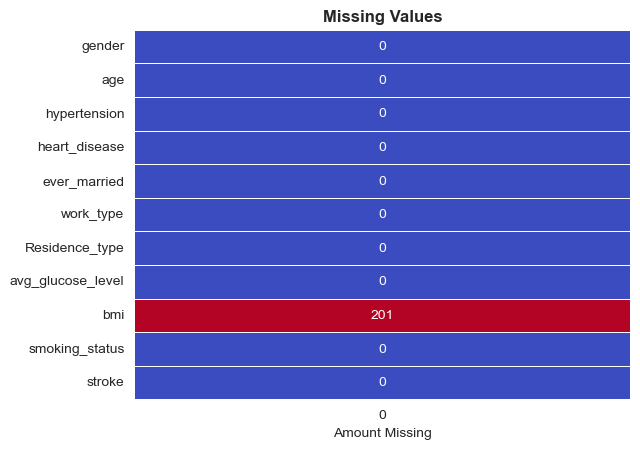

In [6]:
plt.title('Missing Values',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5,cbar=False)
ax.set_xlabel('Amount Missing')
plt.show()

### Fill missing values

In [7]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

Text(0.5, 1.0, 'Stroke')

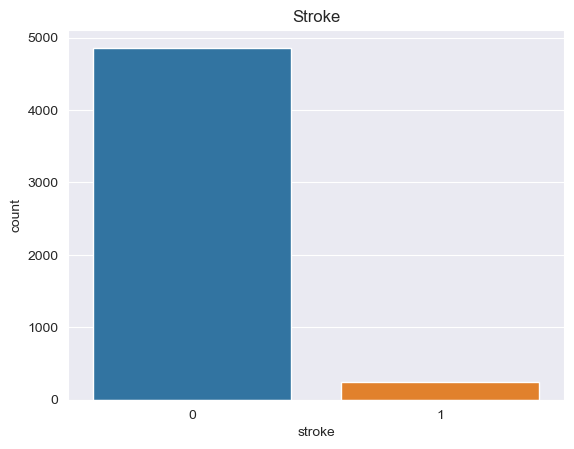

In [8]:
sns.countplot(data=df, x="stroke")
plt.title('Stroke')

# Look at the Data

In [9]:
round (df.describe(exclude = 'object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,5110.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.70,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.80,0.00
50%,45.00,0.0,0.00,91.88,28.40,0.00
75%,61.00,0.0,0.00,114.09,32.80,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [10]:
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


# Numeric Variable Distribution

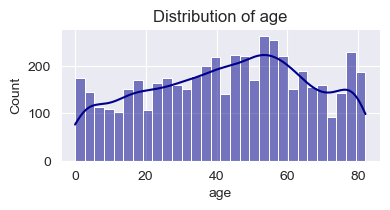

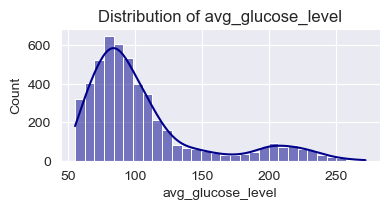

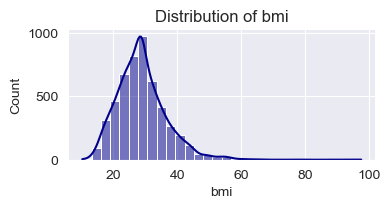

In [11]:

for col in df[['age','avg_glucose_level', 'bmi' ]].columns:
    sns.displot(df[col], bins=30, kde=True, color='darkblue', height=2, aspect=2).set(xlabel=col,title=f'Distribution of {col}')

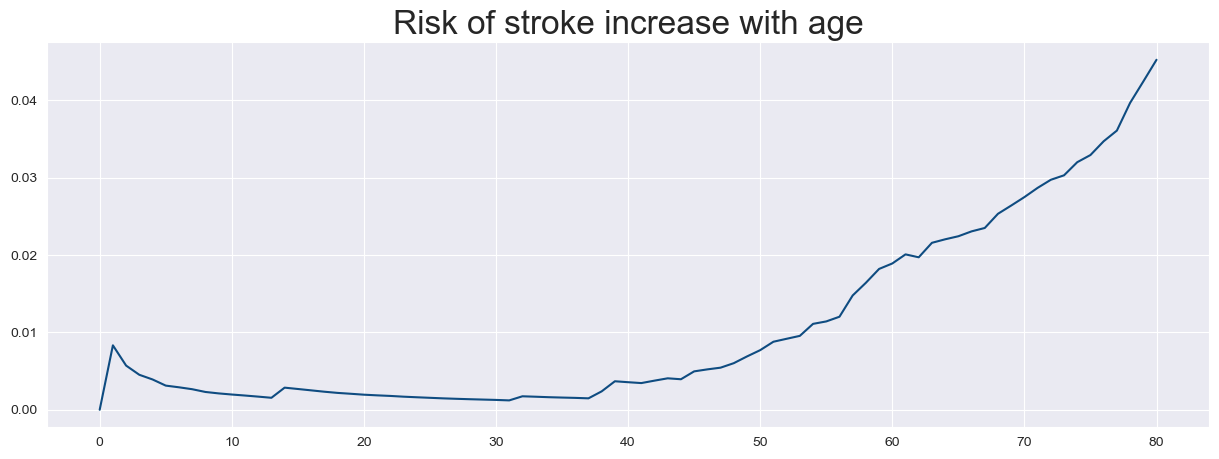

In [12]:
rate = []
ages = df['age'].astype(int)
for i in range(ages.min() + 1, ages.max()):
    rate.append((df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke'])))
    
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=rate,color='#0f4c81', ax = ax).set_title("Risk of stroke increase with age",fontsize=24)
plt.show()

# Model preparation

In [13]:
from sklearn.preprocessing import LabelEncoder

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1})
df['ever_married'] = df['ever_married'].replace({'No':0,'Yes':1})
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1})
df['work_type'] = df['work_type'].replace({'Never_worked':-2,
                                           'children':-1, 
                                           'Private':0,
                                           'Self-employed':1,
                                           'Govt_job':2})

df['smoking_status'] = LabelEncoder().fit_transform(df['smoking_status'])

# Correlations 

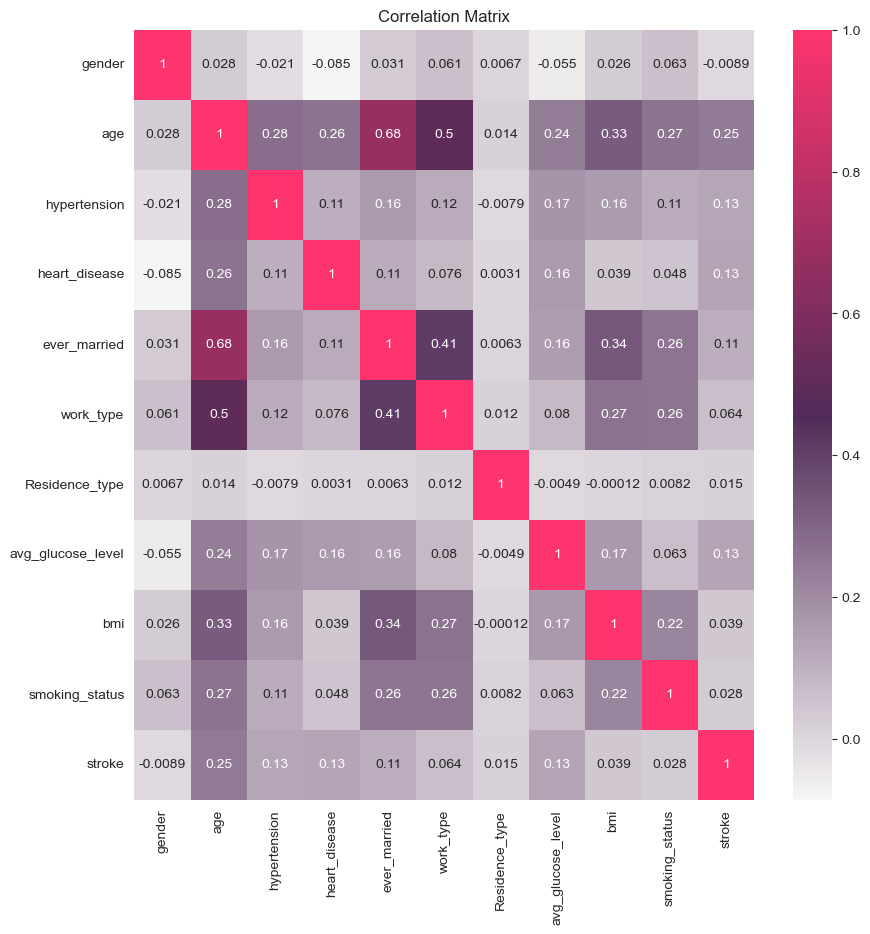

In [14]:
colors = ['#f6f5f5','#512b58','#fe346e']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True,cmap= colormap, facecolor='#f6f5f5', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

## Split dataset

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke'], axis=1)
y = df['stroke']

## Balance dataset

In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
oversampler = SMOTE(sampling_strategy = 1)

# X, y = oversampler.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, y_train = oversampler.fit_resample(X_train, y_train)

<Axes: xlabel='stroke', ylabel='count'>

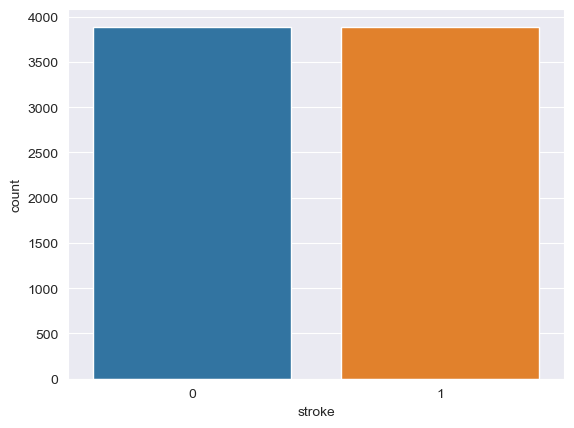

In [18]:
sns.countplot(x=y_train)

## Building Models

### RandomForest

In [19]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix


rf_pipeline = Pipeline(steps = [('KNN', KNeighborsClassifier())])


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# rf_cv = cross_val_score(rf_pipeline,
#                         X,
#                         y,
#                         cv=cv,
#                         scoring=f1)
# print(rf_cv)

# Doing cross validation on whole data, with no train_test_split()
f1_scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='f1')

mean_f1 = f1_scores.mean()

accuracy_scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy')

mean_accuracy = accuracy_scores.mean()

print(f'Mean F1 score: {mean_f1:.3f}')
print(f'Mean accuracy score: {mean_accuracy:.3f}')

Mean F1 score: 0.011
Mean accuracy score: 0.943


In [20]:
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.16      0.54      0.24        50

    accuracy                           0.83      1022
   macro avg       0.56      0.69      0.57      1022
weighted avg       0.93      0.83      0.87      1022



In [22]:
rf_pipeline.score(X_test, y_test)

0.8346379647749511

<Axes: >

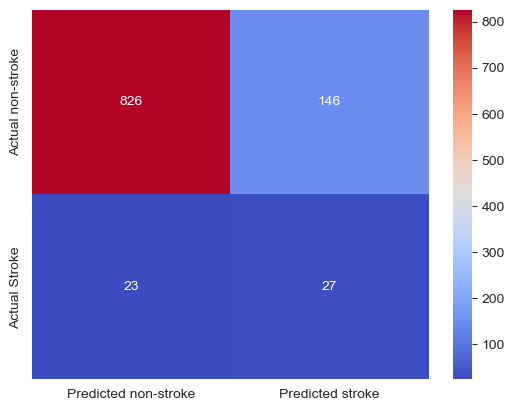

In [23]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm',
            yticklabels=['Actual non-stroke', 'Actual Stroke'],  xticklabels=['Predicted non-stroke', 'Predicted stroke'])

# Building neural network

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [26]:
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

from sklearn.metrics import f1_score
import numpy as np

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [27]:
def select_model(layers, activation):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=X_train.shape[1], activation=activation))
    for i, node in enumerate(layers[1:]):
        model.add(Dense(node, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [28]:
model = KerasClassifier(select_model, verbose=1)

In [29]:
# layers = [[10], [30, 15], [30, 15, 5], [45, 30, 15, 5]]
# activations = ['tanh','relu']

# grid = GridSearchCV(estimator = model, param_grid = dict(layers = layers,
#                                                      activation = activations, 
#                                                     batch_size = [64],
#                                                     epochs=[30]))

# grid_res = grid.fit(X_train, y_train)

In [30]:
# [grid_res.best_score_, grid_res.best_params_]

In [31]:
# model = select_model([45, 30, 15, 5], 'tanh')

In [32]:
# model.fit(X_train, y_train, batch_size=64, epochs=300, validation_data=(X_test, y_test), verbose=2)

In [33]:
# model.save('test_model.md5')

In [34]:
model = load_model('my_model.h5', compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

32/32 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       972
           1       0.21      0.76      0.33        50

    accuracy                           0.85      1022
   macro avg       0.60      0.81      0.63      1022
weighted avg       0.95      0.85      0.89      1022



<Axes: >

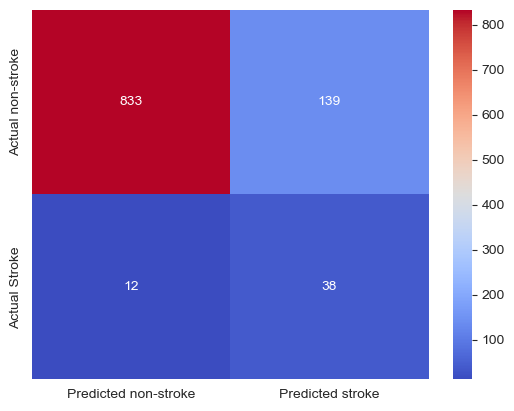

In [35]:
y_pred = model.predict(X_test)

y_pred = y_pred > 0.5

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm',
            yticklabels=['Actual non-stroke', 'Actual Stroke'],  xticklabels=['Predicted non-stroke', 'Predicted stroke'])

# Building models

In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [37]:
def test_models(X_train, y_train, X_test, y_test):
    models = [['KNearest Neighbor Classifier',KNeighborsClassifier(leaf_size=1, n_neighbors=14, p=2)],
              ['Decision Tree Classifier ',DecisionTreeClassifier()],
              ['Random Forest Classifier ',RandomForestClassifier()],
              ['Ada Boost Classifier',AdaBoostClassifier()],
              ['SVM Classifier',SVC(probability=True)],
              ['XG Boost Classifier',XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=100)],
              ['Cat Boost Classifier',CatBoostClassifier(logging_level='Silent')]]

    model_scores = []
    for name, model in models:

        curr_model = model
        curr_model.fit(X_train, y_train)
        curr_model_pred = curr_model.predict(X_test)
        cm_model = confusion_matrix(y_test, curr_model_pred)
        model_scores.append((name, accuracy_score(y_test, curr_model_pred), f1_score(y_test, curr_model_pred)))

        plt.title(name)
        sns.heatmap(confusion_matrix(y_test, curr_model_pred), annot=True, fmt='g', cmap='coolwarm', cbar=False,
            yticklabels=['Actual non-stroke', 'Actual Stroke'], xticklabels=['Predicted non-stroke', 'Predicted stroke'])

        plt.show()

        curr_model_pred_p = curr_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, curr_model_pred_p)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC ({name}) = ' + str(round(roc_auc, 2)))
        plt.legend(loc='lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title(f'ROC curve plot ({name})')
        plt.show()

        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
        print("Cross Validation Score (f1): ", '{0:.2%}'.format(cross_val_score(curr_model, X_train, y_train, cv = cv, scoring = 'f1').mean()))

        print(classification_report(y_test, curr_model_pred))

    return model_scores

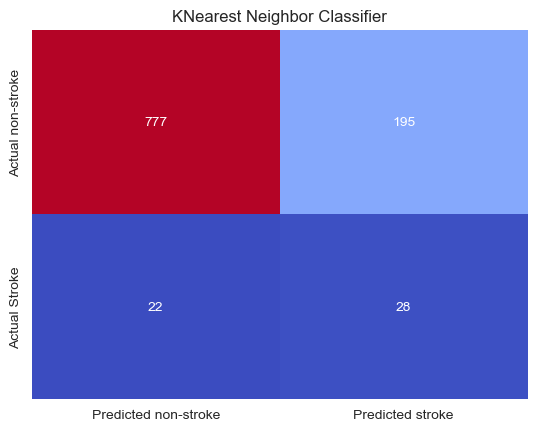

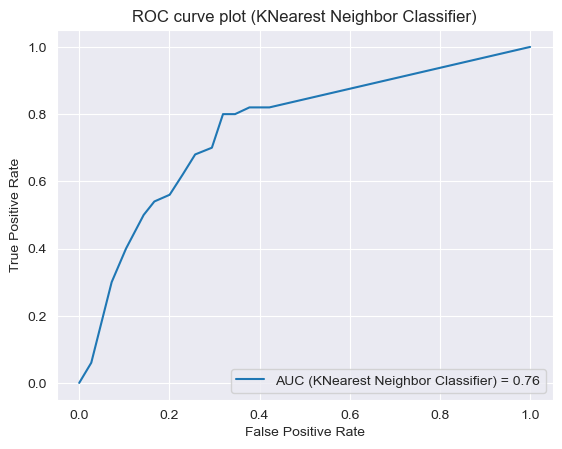

Cross Validation Score (f1):  88.48%
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.56      0.21        50

    accuracy                           0.79      1022
   macro avg       0.55      0.68      0.54      1022
weighted avg       0.93      0.79      0.84      1022



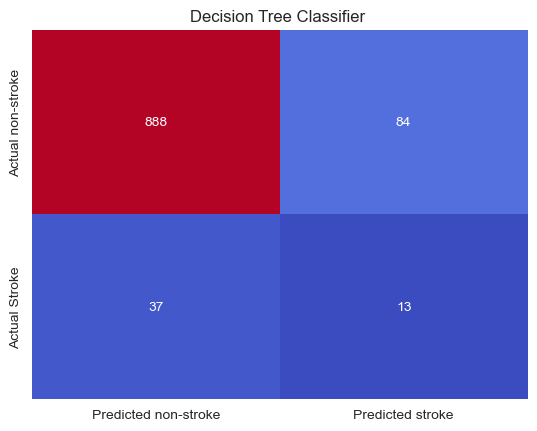

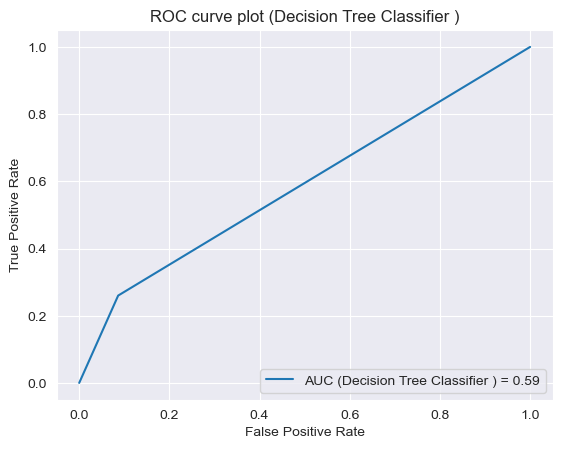

Cross Validation Score (f1):  91.38%
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.13      0.26      0.18        50

    accuracy                           0.88      1022
   macro avg       0.55      0.59      0.56      1022
weighted avg       0.92      0.88      0.90      1022



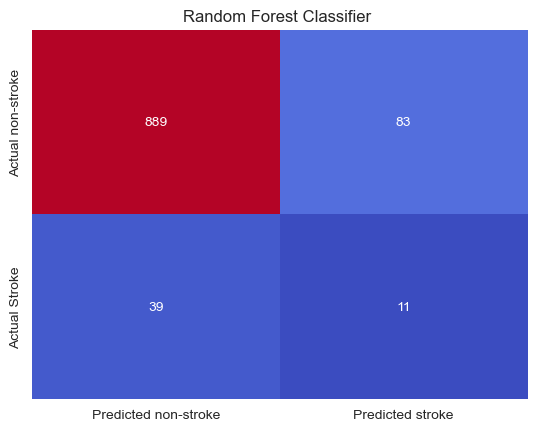

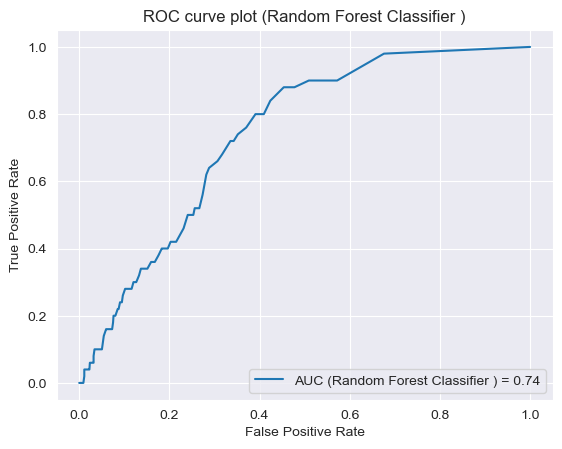

Cross Validation Score (f1):  94.48%
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.12      0.22      0.15        50

    accuracy                           0.88      1022
   macro avg       0.54      0.57      0.54      1022
weighted avg       0.92      0.88      0.90      1022



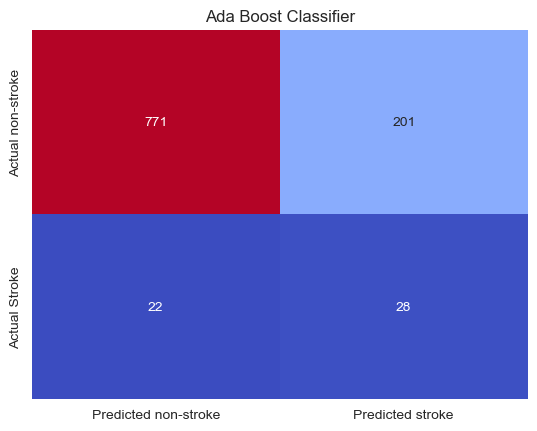

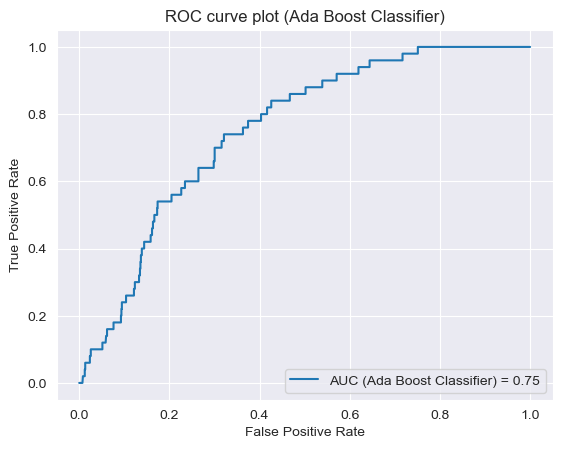

Cross Validation Score (f1):  85.52%
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.56      0.20        50

    accuracy                           0.78      1022
   macro avg       0.55      0.68      0.54      1022
weighted avg       0.93      0.78      0.84      1022



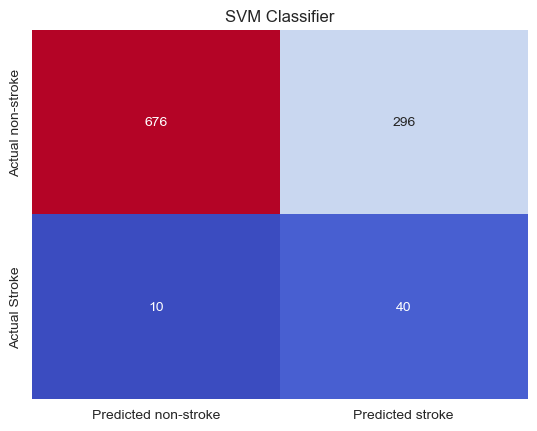

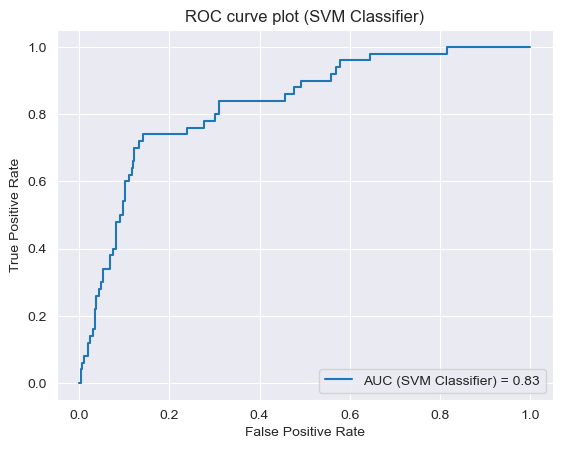

In [ ]:
model_scores = test_models(X_train, y_train, X_test, y_test)